In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [3]:
# Data Preprocessing
train_transforms = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
])

valid_transforms = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
])

test_transforms = valid_transforms

In [4]:
from torch.utils.data import random_split

# Load full dataset from 'train' folder
full_data = datasets.ImageFolder("C:/Users/okeiy/Downloads/Plant_Diseases/train", transform=train_transforms)

# Split 80% train, 10% valid, 10% test
train_size = int(0.8 * len(full_data))
valid_size = int(0.1 * len(full_data))
test_size  = len(full_data) - train_size - valid_size

train_data, valid_data, test_data = random_split(full_data, [train_size, valid_size, test_size])

# DataLoaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_data,  batch_size=32, shuffle=False)

print(f"Classes: {full_data.classes}")
print(f"Number of Classes: {len(full_data.classes)}")
print("")
print(f"Train: {len(train_data)}, Valid: {len(valid_data)}, Test: {len(test_data)}")

Classes: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___

In [5]:
# CNN Model
class PlantCNN(nn.Module):
    def __init__(self, num_classes):
        super(PlantCNN, self).__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        )
        self.fc_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*16*16, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )
    def forward(self, x):
        x = self.conv_layer(x)
        x = self.fc_layer(x)
        return x

num_classes = len(full_data.classes)
model = PlantCNN(num_classes).to(device)
print(model)

PlantCNN(
  (conv_layer): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layer): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=32768, out_features=256, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=256, out_features=38, bias=True)
  )
)


In [6]:
from tqdm import tqdm

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 10
train_losses, valid_losses = [], []
best_val_acc = 0.0

for epoch in range(epochs):
    # Training
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(valid_loader)
    val_acc = 100 * correct / total
    valid_losses.append(avg_val_loss)

    # Print Summary
    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {avg_train_loss:.4f} | "
          f"Valid Loss: {avg_val_loss:.4f} | "
          f"Valid Acc: {val_acc:.2f}%")

    # Save Best Model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")
        print("Saved best model so far")

Epoch 1/10 | Train Loss: 1.5088 | Valid Loss: 0.6860 | Valid Acc: 77.78%
Saved best model so far


Epoch 2/10 | Train Loss: 0.7313 | Valid Loss: 0.4105 | Valid Acc: 86.87%
Saved best model so far


Epoch 3/10 | Train Loss: 0.5283 | Valid Loss: 0.2868 | Valid Acc: 90.38%
Saved best model so far


Epoch 4/10 | Train Loss: 0.4203 | Valid Loss: 0.2750 | Valid Acc: 90.77%
Saved best model so far


Epoch 5/10 | Train Loss: 0.3540 | Valid Loss: 0.2436 | Valid Acc: 92.05%
Saved best model so far


Epoch 6/10 | Train Loss: 0.3052 | Valid Loss: 0.1955 | Valid Acc: 93.63%
Saved best model so far


Epoch 7/10 | Train Loss: 0.2855 | Valid Loss: 0.1821 | Valid Acc: 93.94%
Saved best model so far


Epoch 8/10 | Train Loss: 0.2557 | Valid Loss: 0.1465 | Valid Acc: 94.91%
Saved best model so far


Epoch 9/10 | Train Loss: 0.2393 | Valid Loss: 0.1667 | Valid Acc: 94.42%


Epoch 10/10 | Train Loss: 0.2151 | Valid Loss: 0.1517 | Valid Acc: 95.18%
Saved best model so far


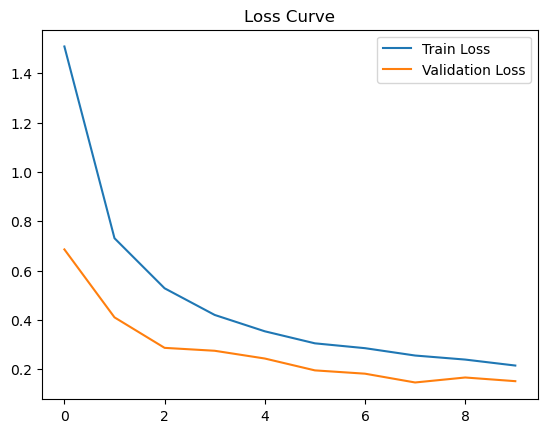

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.95      0.92      0.94       198
                                 Apple___Black_rot       0.95      0.99      0.97       210
                          Apple___Cedar_apple_rust       0.99      0.99      0.99       179
                                   Apple___healthy       0.94      0.92      0.93       201
                               Blueberry___healthy       0.93      0.95      0.94       188
          Cherry_(including_sour)___Powdery_mildew       0.99      0.95      0.97       134
                 Cherry_(including_sour)___healthy       0.98      0.99      0.99       182
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.95      0.93      0.94       174
                       Corn_(maize)___Common_rust_       1.00      1.00      1.00       190
               Corn_(maize)___Northern_Leaf_Blight       0.94      0.94      0.

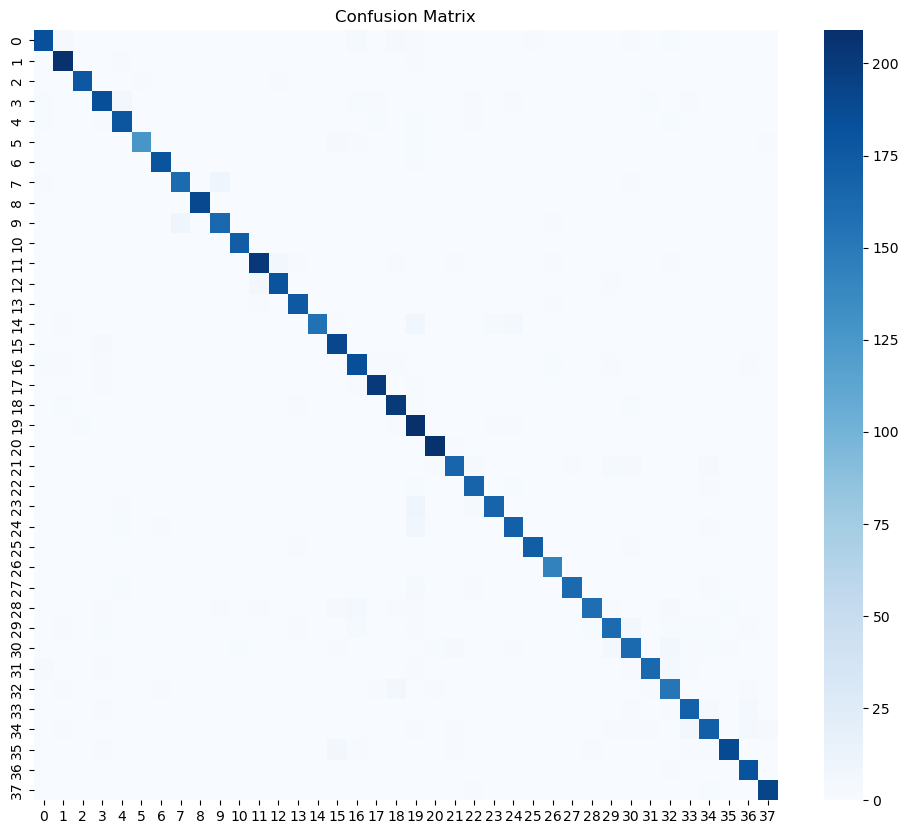

In [7]:
# Plot Loss Curves
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.legend()
plt.title("Loss Curve")
plt.show()

# Test Evaluation
# Reload best model before testing
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(classification_report(all_labels, all_preds, target_names=full_data.classes))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=False, cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

#### Prediction + Visualization

In [8]:
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F

def predict_and_show_topk(image_path, model, transform, class_names, topk=3):
    """
    Predict the top-k classes of a single image and display it with predictions.
    
    Args:
        image_path (str): path to the image
        model (torch.nn.Module): trained model
        transform (torchvision.transforms): same preprocessing as training
        class_names (list): list of class labels
        topk (int): number of top predictions to return
    """
    # Load image
    image = Image.open(image_path).convert("RGB")
    
    # Apply transforms and add batch dimension
    img_tensor = transform(image).unsqueeze(0).to(device)

    # Run prediction
    model.eval()
    with torch.no_grad():
        outputs = model(img_tensor)
        probs = F.softmax(outputs, dim=1)  # convert logits to probabilities
        top_probs, top_indices = probs.topk(topk, dim=1)
    
    # Convert to CPU & numpy
    top_probs = top_probs.cpu().numpy().flatten()
    top_indices = top_indices.cpu().numpy().flatten()
    top_classes = [class_names[i] for i in top_indices]
    
    # Plot image with prediction
    plt.imshow(image)
    plt.title(f"Top-1 Prediction: {top_classes[0]} ({top_probs[0]*100:.2f}%)")
    plt.axis("off")
    plt.show()
    
    # Print top-k predictions
    print("Top Predictions:")
    for cls, prob in zip(top_classes, top_probs):
        print(f"{cls}: {prob*100:.2f}%")
    
    return list(zip(top_classes, top_probs))

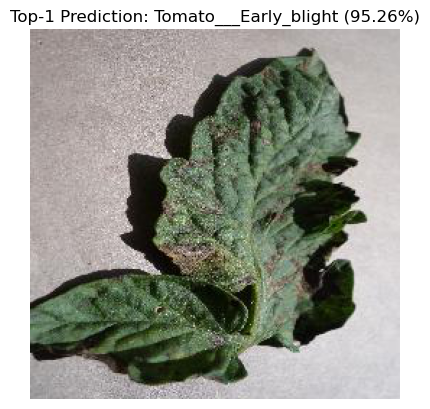

Top Predictions:
Tomato___Early_blight: 95.26%
Tomato___Late_blight: 3.34%
Pepper,_bell___healthy: 1.41%


In [20]:
# Reload best model
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

# Image path
image_path = r"C:\Users\okeiy\Downloads\Plant_Diseases\test\TomatoEarlyBlight5.JPG"

predictions = predict_and_show_topk(image_path, model, test_transforms, full_data.classes, topk=3)

#### Batch Prediction on a Folder of Images

In [21]:
import os
import csv
from PIL import Image
import torch.nn.functional as F

def predict_folder(image_folder, model, transform, class_names, output_file="predictions.csv", topk=3):
    """
    Predict top-k classes for all images in a folder and save results to CSV.
    
    Args:
        image_folder (str): path to folder containing test images
        model (torch.nn.Module): trained model
        transform (torchvision.transforms): same preprocessing as training
        class_names (list): list of class labels
        output_file (str): file name to save predictions
        topk (int): number of top predictions to return
    """
    model.eval()
    results = []

    with torch.no_grad():
        for img_name in os.listdir(image_folder):
            img_path = os.path.join(image_folder, img_name)
            
            # Skip non-image files
            if not img_path.lower().endswith((".jpg", ".jpeg", ".png")):
                continue

            try:
                # Load and preprocess
                image = Image.open(img_path).convert("RGB")
                img_tensor = transform(image).unsqueeze(0).to(device)

                # Predict
                outputs = model(img_tensor)
                probs = F.softmax(outputs, dim=1)
                top_probs, top_indices = probs.topk(topk, dim=1)

                # Convert to CPU
                top_probs = top_probs.cpu().numpy().flatten()
                top_indices = top_indices.cpu().numpy().flatten()
                top_classes = [class_names[i] for i in top_indices]

                # Store result
                results.append([img_name] + [f"{cls} ({prob*100:.2f}%)" for cls, prob in zip(top_classes, top_probs)])

            except Exception as e:
                print(f"Could not process {img_name}: {e}")

    # Save to CSV
    with open(output_file, mode="w", newline="") as f:
        writer = csv.writer(f)
        header = ["Image"] + [f"Top{i+1}" for i in range(topk)]
        writer.writerow(header)
        writer.writerows(results)

    print(f"Predictions saved to {output_file}")
    return results

In [22]:
# Reload best model
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

# Run predictions on folder
image_folder = r"C:\Users\okeiy\Downloads\Plant_Diseases\test"
results = predict_folder(image_folder, model, test_transforms, full_data.classes, output_file="predictions.csv", topk=3)

# Preview first 5 results
for row in results[:5]:
    print(row)

Predictions saved to predictions.csv
['AppleCedarRust1.JPG', 'Apple___Cedar_apple_rust (99.91%)', 'Blueberry___healthy (0.09%)', 'Apple___Black_rot (0.00%)']
['AppleCedarRust2.JPG', 'Apple___Cedar_apple_rust (99.64%)', 'Tomato___Bacterial_spot (0.35%)', 'Grape___Black_rot (0.01%)']
['AppleCedarRust3.JPG', 'Apple___Cedar_apple_rust (99.99%)', 'Tomato___Late_blight (0.01%)', 'Tomato___Bacterial_spot (0.01%)']
['AppleCedarRust4.JPG', 'Apple___Cedar_apple_rust (99.71%)', 'Tomato___Bacterial_spot (0.29%)', 'Grape___Black_rot (0.00%)']
['AppleScab1.JPG', 'Orange___Haunglongbing_(Citrus_greening) (89.13%)', 'Apple___Apple_scab (5.75%)', 'Pepper,_bell___healthy (3.62%)']
